# Time Series Analysis with Twitter and CDC data

In [87]:
import warnings
warnings.filterwarnings('ignore')

# Load required libraries
import pandas as pd
from pandas import Series
import matplotlib.pyplot as plt
%matplotlib inline
from datetime import datetime
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
import numpy as np

#http://people.duke.edu/~rnau/whatuse.htm
#m/2016/03/22/time-series-seasonal-ARIMA-model-in-python/

## Cleaning Data

### CDC Data Cleaning

In [77]:
#http://www.cs.uml.edu/~bliu/pub/CPNS_2011.pdf
cdc_df = pd.read_csv('FluViewPhase2Data/ILINet.csv')
cdc_df.reset_index(inplace=True) # Resets the index, makes factor a column
cdc_df.drop('PERCENTAGE OF VISITS FOR INFLUENZA-LIKE-ILLNESS REPORTED BY SENTINEL PROVIDERS',axis=1,inplace=True) # drop factor from axis 1 and make changes permanent by inplace=True
cdc_df.columns = cdc_df.iloc[0]
cdc_df = cdc_df.iloc[1:]
print(cdc_df.columns)
cdc_df = cdc_df.drop(['REGION TYPE', 'REGION', 'AGE 0-4', 'AGE 25-49', 'AGE 25-64', 'AGE 5-24',
       'AGE 50-64', 'AGE 65', 'NUM. OF PROVIDERS'], axis=1)

Index(['REGION TYPE', 'REGION', 'YEAR', 'WEEK', '% WEIGHTED ILI',
       '%UNWEIGHTED ILI', 'AGE 0-4', 'AGE 25-49', 'AGE 25-64', 'AGE 5-24',
       'AGE 50-64', 'AGE 65', 'ILITOTAL', 'NUM. OF PROVIDERS'],
      dtype='object', name=0)


In [78]:
cdc_df["Date"] = pd.to_datetime(cdc_df.WEEK.astype(str)+
                          cdc_df.YEAR.astype(str).add('-1') ,format='%W%Y-%w')
cdc_df.set_index(cdc_df['Date'], inplace=True)
cdc_df.drop(['Date', 'YEAR', 'WEEK', '% WEIGHTED ILI', '%UNWEIGHTED ILI'], axis=1, inplace=True)
cdc_df['ILITOTAL'] = cdc_df['ILITOTAL'].astype('int64')

In [79]:
len(cdc_df)

50

### Google Search Trends

In [62]:
google_df = pd.read_csv('google_trends/multiTimeline.csv')
google_df.reset_index(inplace=True) # Resets the index, makes factor a column
google_df.columns = google_df.iloc[0]
google_df = google_df.iloc[1:]
google_df.head()

,Week,flu: (United States)
1,2017-10-02,18
2,2017-10-09,18
3,2017-10-16,18
4,2017-10-22,18
5,2017-10-30,16


In [63]:
google_df.rename(columns={'Week': 'Date'}, inplace=True)
google_df.rename(columns={'flu: (United States)': 'Count'}, inplace=True)
google_df.set_index(google_df['Date'], inplace=True)
google_df.drop(['Date'], axis=1, inplace=True)
google_df['Count'] = google_df['Count'].astype('int64')

### Twitter Cleaning

In [ ]:
#will need to delete retweets, tweets from the same user within a week (not a new case)
#normalize scale of CDC visits and tweets 

## Visualizations

In [1]:
#include framework model here -- tracking influenza-like illness 

### CDC ILI Visits 2017-2018

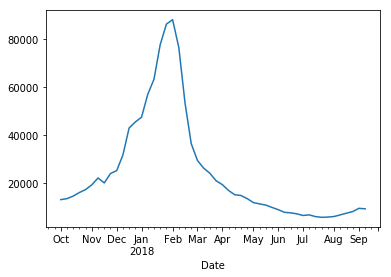

In [68]:
#show distribution (count of flu-related tweets) over time 
#https://github.com/learn-co-students/ds-ts-visualize_ts-nyc-career-ds-062518/tree/solution
#need Pandas Series with date and tweet count per date 
#overlay with CDC data to see how it corresponds -- have dropdown menu 
cdc_df.plot()
plt.legend().set_visible(False)
plt.show()

In [70]:
#maybe heat map by month and week
# plt.matshow(cdc_df, interpolation=None, aspect='auto', cmap=plt.cm.Spectral_r)
# plt.show()

### Google Trends Data 2017-2018 ('Flu')

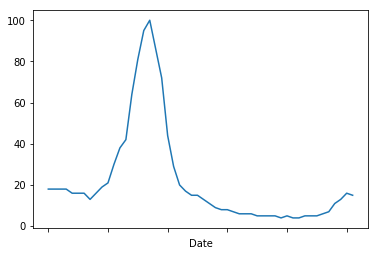

In [69]:
google_df.plot()
plt.legend().set_visible(False)
plt.show()

### Flu-Related Tweets 2017-2018 

In [ ]:
twitter_df.plot()
plt.legend().set_visible(False)
plt.show()

## Assessing Stationarity

In [96]:
#Determing rolling statistics
moving_avg = cdc_df.rolling(4).mean() #4 week lag
moving_std = cdc_df.rolling(4).std()

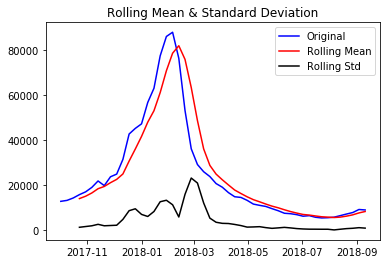

In [97]:
#Plot rolling statistics
orig = plt.plot(cdc_df, color='blue',label='Original')
mean = plt.plot(moving_avg, color='red', label='Rolling Mean')
std = plt.plot(moving_std, color='black', label = 'Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show(block=False)
#mean and standard deviation increasing with time = not stationary

### Dickey-Fuller Test

In [98]:
# Perform the dickey Fuller test 
print ('Results of Dickey-Fuller Test:')
dftest = adfuller(cdc_df['ILITOTAL'], autolag='AIC')

# Extract and display test results in a user friendly manner
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print (dfoutput)
#null: time-series is non-stationary 
#p-value: 0.429
#p-value > 0.05, fail to reject null --> time-series is non-stationary

Results of Dickey-Fuller Test:
Test Statistic                 -1.702719
p-value                         0.429712
#Lags Used                      2.000000
Number of Observations Used    47.000000
Critical Value (1%)            -3.577848
Critical Value (5%)            -2.925338
Critical Value (10%)           -2.600774
dtype: float64


### Decomposition Visualization

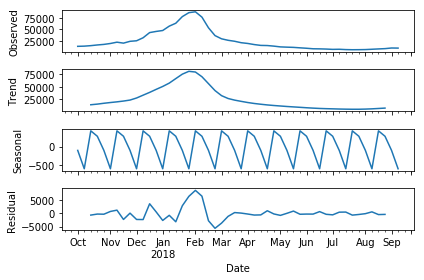

In [100]:
result = seasonal_decompose(cdc_df, freq=4) #every 4 weeks
result.plot()
plt.show()

## Stationarization of Data

In [ ]:
#linear regression assumption that observations are independent of each other: data needs to be stationary

### Differencing

In [ ]:
#take the difference of the observation at a particular instant with that at the previous instant
# Calculate the difference of log transformed ts with shifted log transformed ts and plot.
cdc_log = np.log(cdc_df)
ts_log_diff = ts_log - ts_log.shift()

rcParams['figure.figsize'] = 15, 6
plt.plot(ts_log_diff)

## Correlation between CDC reports and ILI-tweets

### Auto-Correlation 

In [ ]:
#check auto-correlation to assess seasonality? (maybe)

### Pearson Correlation Coefficient

In [8]:
#pearson correlation coefficient between CDC ILI visits and ILI tweets 

## Seasonal ARIMA Modeling to Forecast Influenza-Like Cases

In [ ]:
#predict ILI incidence as a linear function of current and 
#old Social Network data and historical ILI data (CDC data) -- assess model goodness of fit with AIC, lowest value 
#https://github.com/learn-co-students/ds-ts-ARIMA-nyc-career-ds-062518/tree/solution

### Model with CDC data only

### Model with CDC & Twitter data

### Model Selection: Overview of Goodness-of-Fit Measures

### Model Validation: Forecasting

In [9]:
#one-step ahead forecasting for best fitting model - comparing predicted values to real values of the time series, 
#which will help us understand the accuracy of our forecasts (use cross-fold validation)

## Producing & Visualizing Forecasts